In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [167]:
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [169]:
from glob import glob 
glob('*')

['main.ipynb', 'Loan_Dataset.csv', 'README.md', 'Loan_Dataset_cleaned.csv']

In [170]:
df = pd.read_csv('Loan_Dataset.csv')

In [171]:
df.head()

,id,grade,annual_income,short_employee,emp_length_num,home_ownership,Debt-To-Income Ratio,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_income          20000 non-null  int64  
 3   short_employee         20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   Debt-To-Income Ratio   19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

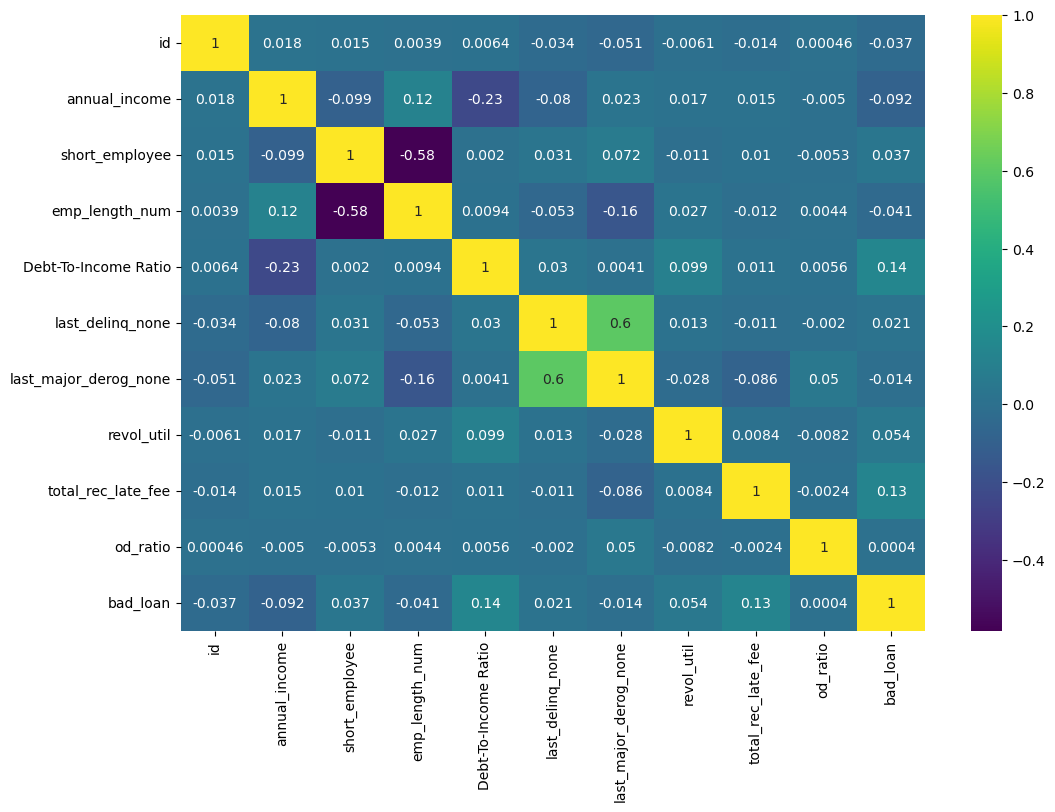

In [173]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='viridis')
plt.show()

Notice emp_length_num and short_employee are negatively correlated. <br>
emp_length_num means the number of years worked (in years). It ranges from 0 to 10, where 0 means less than a year and 10 means a decade or more. <br>
short_employee is 1 when the borrower has been employed for 1 year or less.<br> <br>
last_major_derog_none and last_delinq_none are positively correlated. <br> 
last_major_derog_none is 1 when the loaner has a bad rating for at least 90 days. <br> 
last_delinq_none is 1 when the debit has been in default at least once.

In [175]:
df.emp_length_num.describe()

count    20000.00000
mean         6.82140
std          3.77423
min          0.00000
25%          3.00000
50%          7.00000
75%         11.00000
max         11.00000
Name: emp_length_num, dtype: float64

In [176]:
df.short_employee.value_counts()

short_employee
0    17750
1     2250
Name: count, dtype: int64

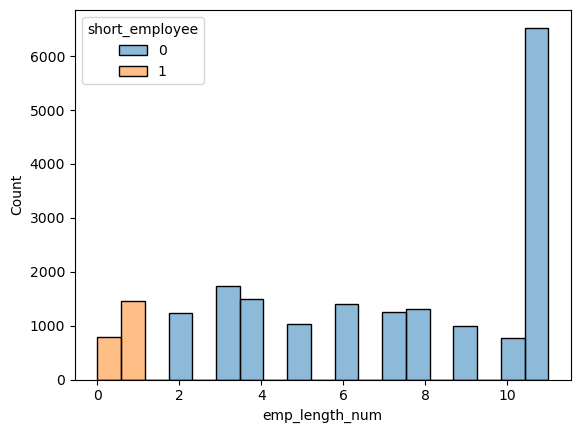

In [177]:
sns.histplot(x='emp_length_num',
                hue = 'short_employee', 
                data=df)
plt.show()

Drop the short_employee variable.

In [179]:
df.drop(columns = ['short_employee'], inplace=True)

In [191]:
df['last_major_derog_none'].value_counts()

last_major_derog_none
1.0    436
0.0    138
Name: count, dtype: int64

In [194]:
df['last_delinq_none'].value_counts()

last_delinq_none
1    10932
0     9068
Name: count, dtype: int64

Drop the last_major_derog_none variable as it has a lot of missing values and last_delinq_none may carry some of its information.

In [198]:
df.drop(columns = ['last_major_derog_none'], inplace=True)

### Data Cleaning - Missing Data

In [201]:
for col in df.columns:
    if df[col].isna().sum()/df.shape[0] > 0.00:
        print(f'The percentage of missing data in column {col} is: {df[col].isna().sum()/df.shape[0]*100:.2f}%.')

The percentage of missing data in column home_ownership is: 7.46%.
The percentage of missing data in column Debt-To-Income Ratio is: 0.77%.


<br> is missing values related to the target?<br> 
 - if yes, then we should not just drop all the rows with missing home_ownership values. <br> 
 - if no, then we can drop those rows. <br>
will use chi-square test to check.

In [204]:
df.home_ownership.value_counts()

home_ownership
MORTGAGE    9844
RENT        7052
OWN         1613
Name: count, dtype: int64

In [206]:
df['Debt-To-Income Ratio'].describe()

count    19846.000000
mean        16.587841
std          7.585812
min          0.000000
25%         10.852500
50%         16.190000
75%         22.060000
max         34.990000
Name: Debt-To-Income Ratio, dtype: float64

In [210]:
df.fillna('NA',inplace=True)

In [212]:
df.home_ownership.value_counts()

home_ownership
MORTGAGE    9844
RENT        7052
OWN         1613
NA          1491
Name: count, dtype: int64

In [214]:
table_ho = pd.crosstab(df.bad_loan, df.home_ownership,margins=True, margins_name='Total')
table_ho

home_ownership,MORTGAGE,NA,OWN,RENT,Total
bad_loan,,,,,
0,8136,1199,1297,5368,16000
1,1708,292,316,1684,4000
Total,9844,1491,1613,7052,20000


In [216]:
table = list(table_ho.loc[[0,1],'NA']), list(table_ho.loc[[0,1],'Total'])
table

([1199, 292], [16000, 4000])

In [218]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat:.2f}. \nP-value is {p_value:.2f}. \nDegrees of freedom is {dof}. \nReject the null hypothesis. The number of missing values in home_ownership and bad_loan are dependent. Observations with missing home_ownership values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat:.2}. \nP-value is {p_value:.2}. \nDegrees of freedom is {dof}. \nFail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.')

print(f'\nExpected values are:\n {expected_values}')

Chi-square Statistic is 0.13. 
P-value is 0.72. 
Degrees of freedom is 1. 
Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.

Expected values are:
 [[ 1193.23014285   297.76985715]
 [16005.76985715  3994.23014285]]


In [220]:
row_num_be4 = df.shape[0]
row_num_to_drop = df.home_ownership.value_counts()['NA']

df = df[df.home_ownership!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

do the same thing for debt to income ratio

In [223]:
dti_ratio = df['Debt-To-Income Ratio'].apply(lambda x: 'non-NA' if x != 'NA' else 'NA')
table_dti = pd.crosstab(df.bad_loan, dti_ratio, margins=True, margins_name='Total')
table_dti

Debt-To-Income Ratio,NA,non-NA,Total
bad_loan,,,
0,113,14688,14801
1,25,3683,3708
Total,138,18371,18509


In [225]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_dti)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat: .2f}. \nP-value is {p_value: .2f}. \nDegrees of freedom is {dof}. \nReject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are dependent. Observations with missing debt-to-income_ratio values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat: .2f}. \nP-value is {p_value: .2f}. \nDegrees of freedom is {dof}. \nFail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.')

print(f'\nExpected values are:\n {expected_values}')

Chi-square Statistic is  0.32. 
P-value is  0.99. 
Degrees of freedom is 4. 
Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.

Expected values are:
 [[  110.35377384 14690.64622616 14801.        ]
 [   27.64622616  3680.35377384  3708.        ]
 [  138.         18371.         18509.        ]]


In [227]:
row_num_be4 = df.shape[0]
row_num_to_drop = df['Debt-To-Income Ratio'].value_counts()['NA']

df = df[df['Debt-To-Income Ratio']!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [229]:
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].astype(float)
df['last_delinq_none'] = df['last_delinq_none'].astype(object)

In [231]:
#clean up term values
df.term.value_counts()
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 Months' else x)
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 months' else x)
df.term = df.term.apply(lambda x: '60 months' if x == ' 60 months' else x)
df.term.value_counts()

term
36 months    13754
60 months     4617
Name: count, dtype: int64

In [233]:
#after dropping all the rows with missing info, there is no more missing value
(df=='NA').sum(axis=0).sum()

0

### Data Cleaning - Duplicates

In [236]:
df.duplicated().sum()

0

### Data Cleaning - Outliers, Skewness

In [239]:
df.describe()

,id,annual_income,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,1.837100e+04,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000
mean,7.594628e+06,73421.273257,6.827609,16.590894,56.001801,0.293404,0.504941,0.200479
std,1.609952e+06,45612.958798,3.769322,7.582902,43.411698,3.140913,0.287800,0.400370
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000
25%,6.206280e+06,47000.000000,3.000000,10.850000,38.750000,0.000000,0.257495,0.000000
50%,7.379923e+06,65000.000000,7.000000,16.220000,57.100000,0.000000,0.507883,0.000000
75%,8.776061e+06,88000.000000,11.000000,22.060000,74.000000,0.000000,0.753875,0.000000
max,1.145464e+07,1000000.000000,11.000000,34.990000,5010.000000,96.466600,0.999894,1.000000


Perhaps outliers in annual_income, revol_util and total_rec_late_fee?

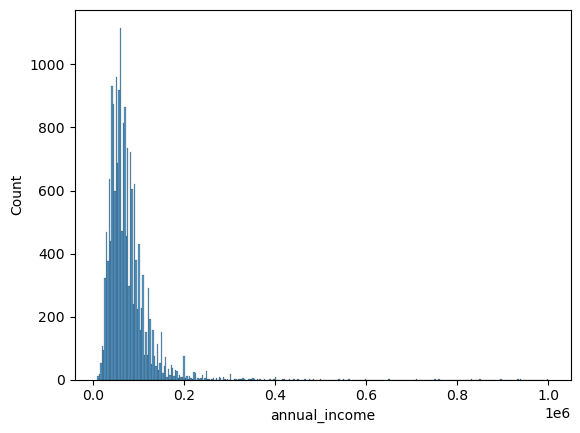

In [242]:
sns.histplot(x='annual_income', data=df)
plt.show()

annual_income looks skewed. try log and sqrt transformation

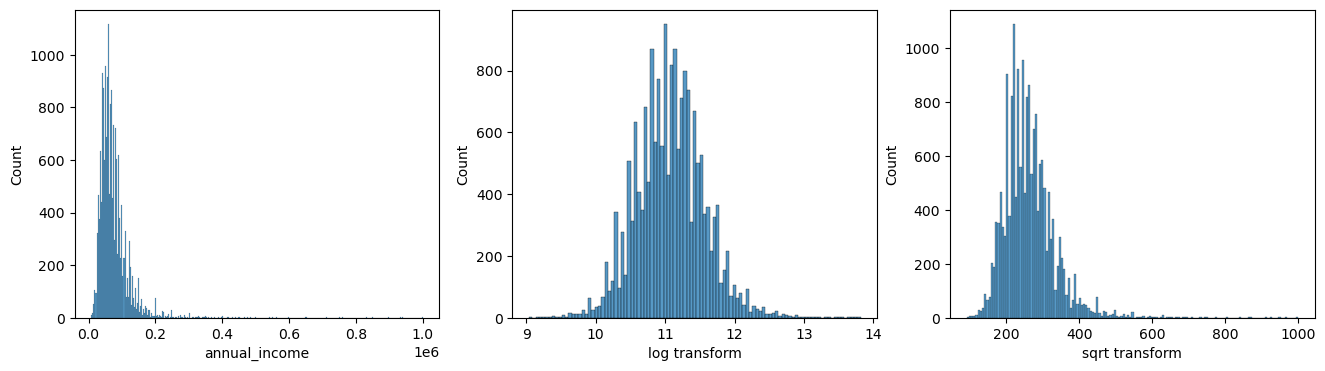

In [245]:
fig, ax = plt.subplots(1, 3, figsize = (16,4))
sns.histplot(x=df.annual_income, ax=ax[0]);
sns.histplot(x=df.annual_income.apply(lambda x: x+1).apply(np.log), ax=ax[1]);
ax[1].set_xlabel('log transform');
sns.histplot(x=df.annual_income.apply(np.sqrt), ax=ax[2]);
ax[2].set_xlabel('sqrt transform');

use log

In [248]:
df['annual_income_log'] = df.annual_income.apply(lambda x: x+1).apply(np.log)

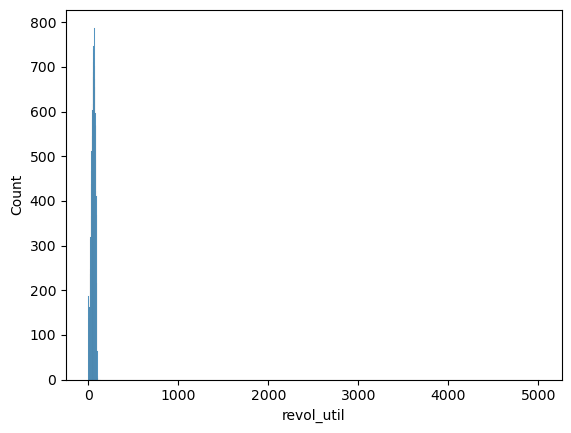

In [250]:
sns.histplot(x='revol_util',data=df)
plt.show()

In [252]:
df.revol_util.nlargest(10)

100      5010.0
2643      128.1
7880      112.9
19809     109.1
11712     107.7
7208      106.9
16563     106.1
12516     105.8
4948      105.3
17394     103.5
Name: revol_util, dtype: float64

In [254]:
df = df[df.revol_util!=df.revol_util.nlargest(1).iloc[0]]
df.shape

(18370, 14)

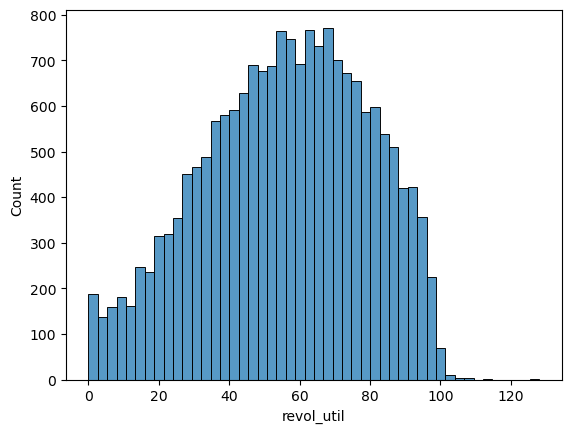

In [256]:
sns.histplot(x='revol_util', data=df)
plt.show()

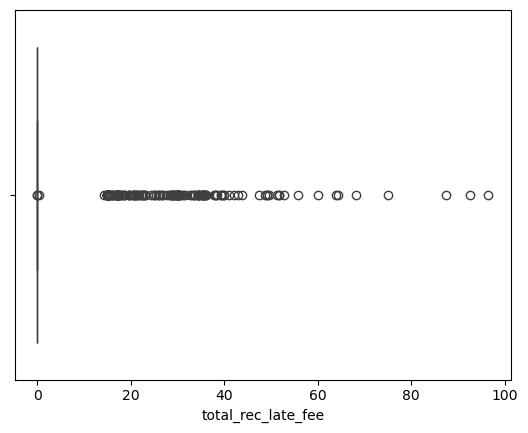

In [258]:
sns.boxplot(x='total_rec_late_fee', data=df)
plt.show()

In [260]:
(df.total_rec_late_fee == 0).sum()/df.shape[0]

0.9884594447468699

almost 99% of the data in total_rec_late_fee (Late fees received so far) is 0. Will convert it into a categorical variable with two values - zero, non-zero.

In [263]:
df['total_rec_late_fee_cat'] = df.total_rec_late_fee.apply(lambda x: 'zero' if x == 0 else 'non-zero')

In [265]:
df['total_rec_late_fee_cat'].value_counts()

total_rec_late_fee_cat
zero        18158
non-zero      212
Name: count, dtype: int64

In [267]:
df.reset_index(drop=True, inplace=True)

In [269]:
df.drop(columns = ['annual_income', 'total_rec_late_fee'], inplace=True)

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      18370 non-null  int64  
 1   grade                   18370 non-null  object 
 2   emp_length_num          18370 non-null  int64  
 3   home_ownership          18370 non-null  object 
 4   Debt-To-Income Ratio    18370 non-null  float64
 5   purpose                 18370 non-null  object 
 6   term                    18370 non-null  object 
 7   last_delinq_none        18370 non-null  object 
 8   revol_util              18370 non-null  float64
 9   od_ratio                18370 non-null  float64
 10  bad_loan                18370 non-null  int64  
 11  annual_income_log       18370 non-null  float64
 12  total_rec_late_fee_cat  18370 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 1.8+ MB


In [273]:
df.to_csv('Loan_Dataset_cleaned.csv', index=False)

<br> Loan default is a rare case. This is an unbalanced dataset.

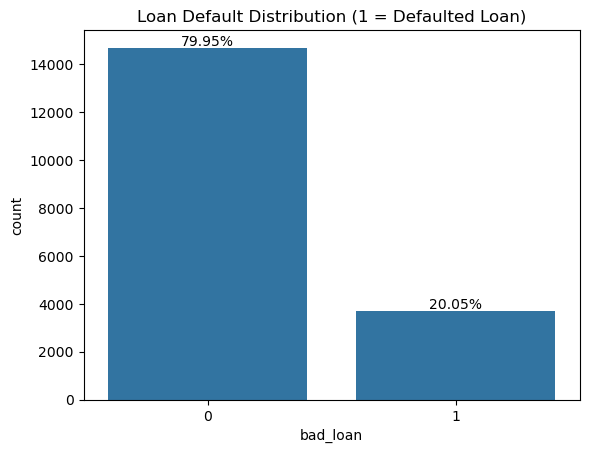

In [276]:
total_count = df.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

### Exploratory Data Analysis - Categorical Variables

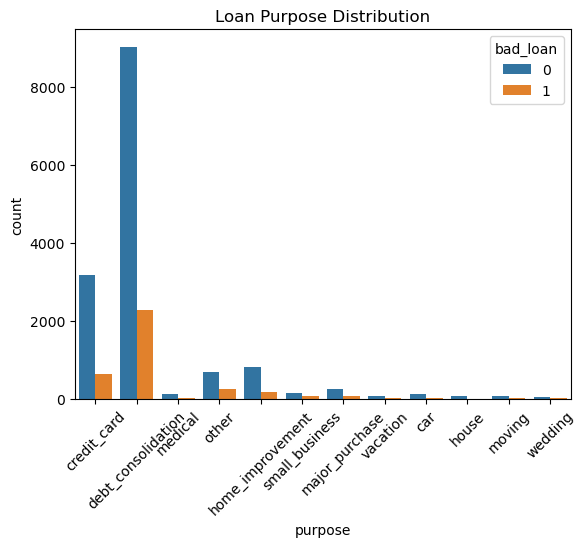

In [279]:
sns.countplot(x=df.purpose, hue=df.bad_loan);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

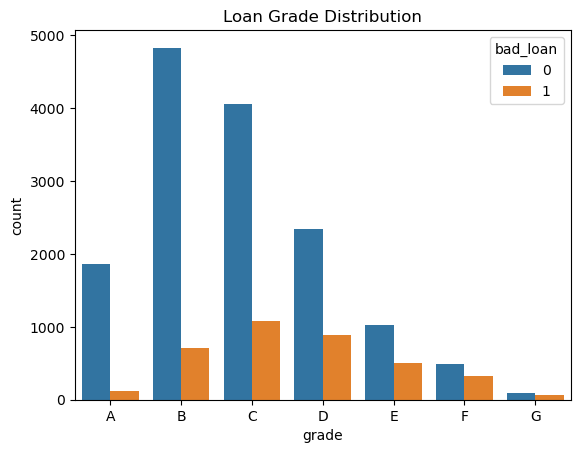

In [281]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order);
plt.title('Loan Grade Distribution');

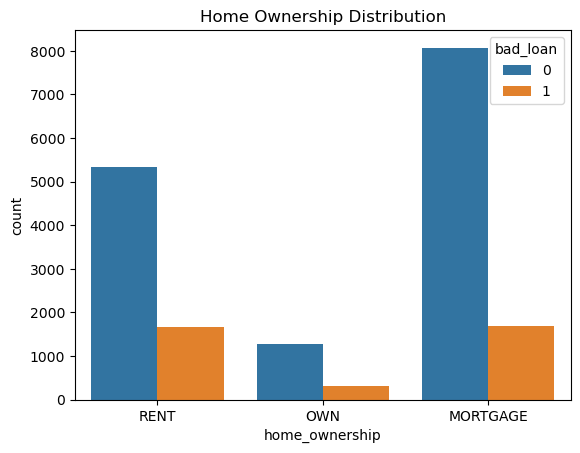

In [283]:
sns.countplot(x=df.home_ownership, hue=df.bad_loan);
plt.title('Home Ownership Distribution');

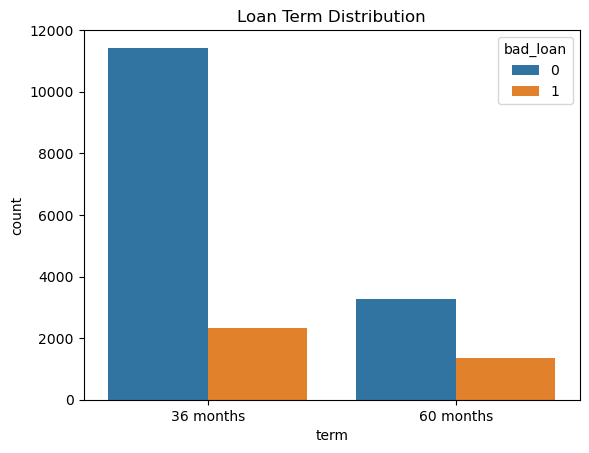

In [285]:
sns.countplot(x=df.term, hue=df.bad_loan);
plt.title('Loan Term Distribution');

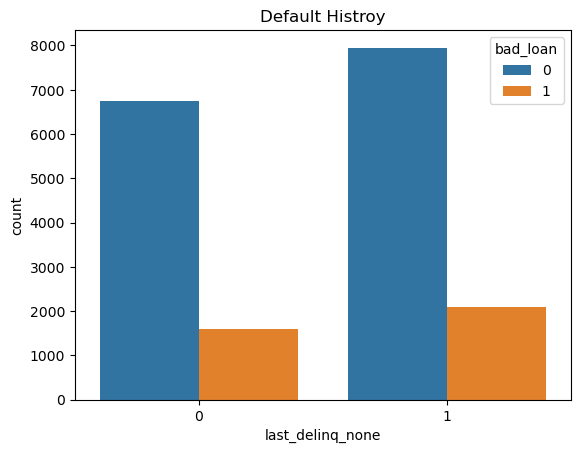

In [287]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan);
plt.title('Default Histroy');

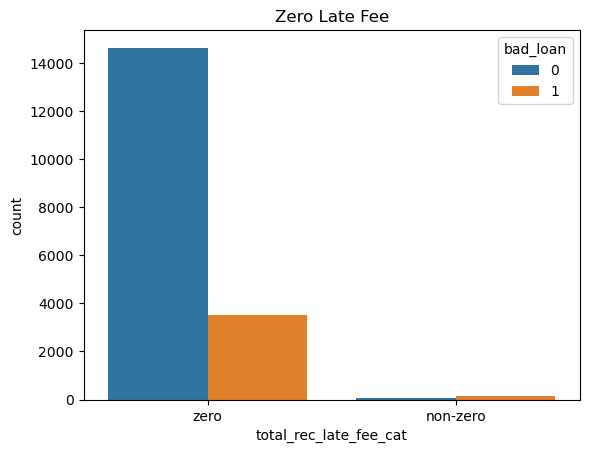

In [293]:
sns.countplot(x=df.total_rec_late_fee_cat, hue=df.bad_loan);
plt.title('Zero Late Fee');

### Exploratory Data Analysis -  Continuous Variables

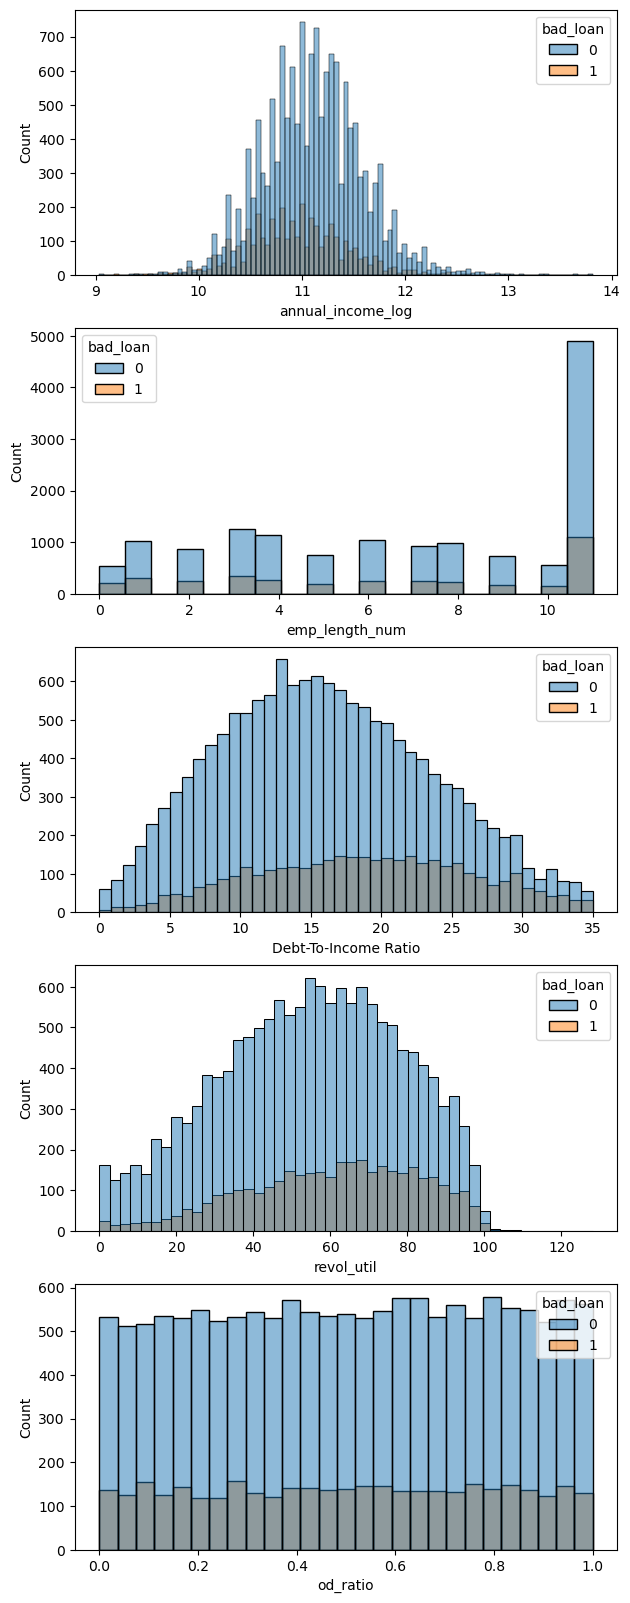

In [295]:
fig,ax = plt.subplots(5,1,figsize=(7,20))

sns.histplot(x='annual_income_log',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[0]);

sns.histplot(x='emp_length_num',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[1]);

sns.histplot(x='Debt-To-Income Ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.histplot(x='revol_util',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.histplot(x='od_ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[4]);

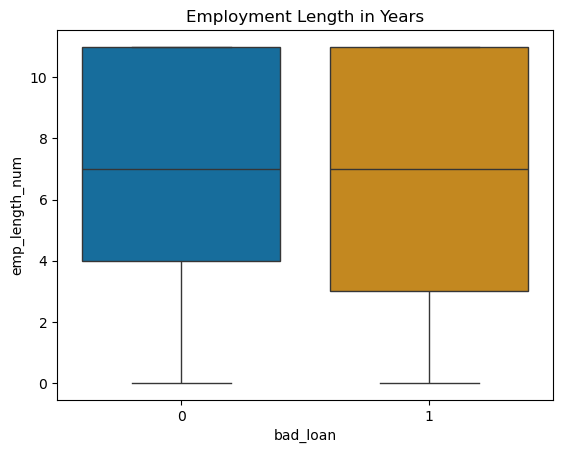

In [311]:
sns.boxplot(y='emp_length_num',
            x ='bad_loan',
            data=df,
            palette='colorblind');
plt.title('Employment Length in Years')
plt.show()

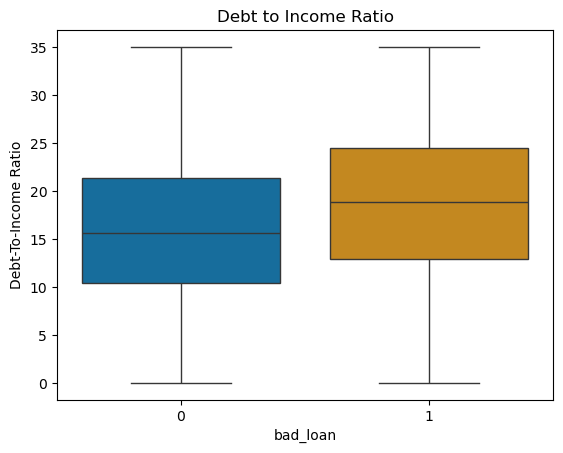

In [313]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df,
           palette='colorblind');
plt.title('Debt to Income Ratio')
plt.show()

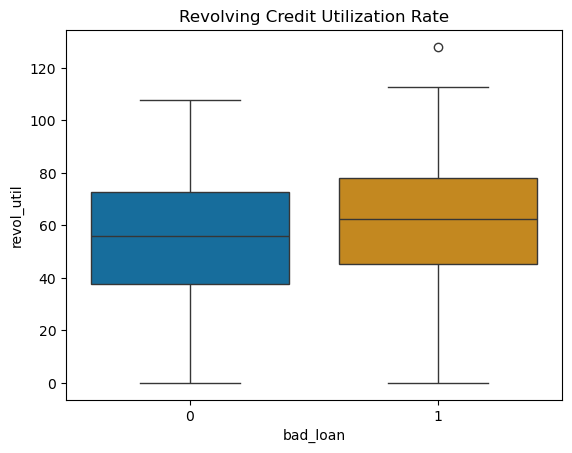

In [315]:
sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df,
            palette='colorblind');
plt.title('Revolving Credit Utilization Rate')
plt.show()

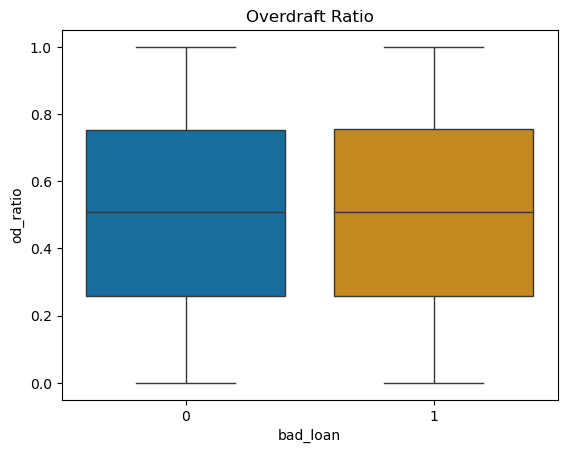

In [322]:
sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df,
           palette='colorblind');
plt.title('Overdraft Ratio')
plt.show()

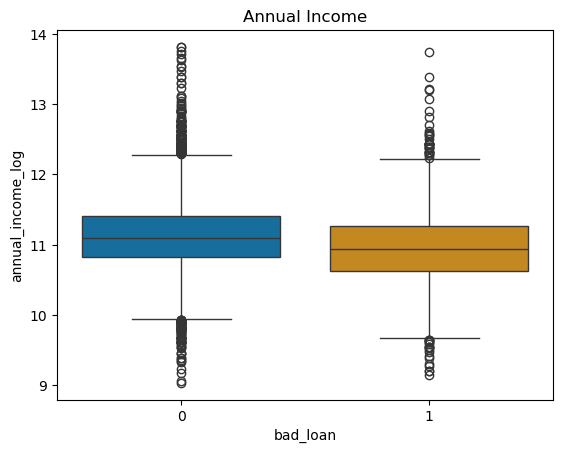

In [318]:
sns.boxplot(y='annual_income_log',
                x = 'bad_loan', 
                data=df,
           palette='colorblind');
plt.title('Annual Income')
plt.show()

### Feature Engineering - One-Hot Encoding

In [324]:
pd.get_dummies(df).shape

(18370, 35)

In [326]:
pd.get_dummies(df).columns

Index(['id', 'emp_length_num', 'Debt-To-Income Ratio', 'revol_util',
       'od_ratio', 'bad_loan', 'annual_income_log', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1', 'total_rec_late_fee_cat_non-zero',
       'total_rec_late_fee_cat_zero'],
      dtype='object')

In [328]:
df = pd.get_dummies(df)

In [330]:
df.to_csv('Loan_Dataset_final.csv', index=False)

In [332]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [334]:
X = df.drop(columns=['id', 
                     'bad_loan',
                     'grade_A',
                     'home_ownership_MORTGAGE',
                     'purpose_car',
                     'term_36 months',
                     'last_delinq_none_0', 
                     'total_rec_late_fee_cat_zero'])

#1 represents bad loan. 0 represents good loan
y = df['bad_loan'].astype(int)

In [336]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   emp_length_num                   18370 non-null  int64  
 1   Debt-To-Income Ratio             18370 non-null  float64
 2   revol_util                       18370 non-null  float64
 3   od_ratio                         18370 non-null  float64
 4   annual_income_log                18370 non-null  float64
 5   grade_B                          18370 non-null  bool   
 6   grade_C                          18370 non-null  bool   
 7   grade_D                          18370 non-null  bool   
 8   grade_E                          18370 non-null  bool   
 9   grade_F                          18370 non-null  bool   
 10  grade_G                          18370 non-null  bool   
 11  home_ownership_OWN               18370 non-null  bool   
 12  home_ownership_REN

In [338]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [340]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [342]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

### Logistic Regression

In [344]:
param_grid = [{'C': [1, 10, 100, 1000]}]

lg_clf = LogisticRegression(class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                           #AP summarizes a precision-recall curve as the weighted mean of precisions achieved at 
                           #each threshold, with the increase in recall from the previous threshold used as the weight
                           #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
                          return_train_score = True)
               
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 100}

In [345]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1922,1015
Actual Positive,244,493


In [346]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.39. ROC AUC is 0.71, Accuracy is 0.66


In [347]:
lg_clf.coef_

array([[-0.06273242,  0.2509725 ,  0.12760428, -0.00228508, -0.29982506,
         0.25140424,  0.44475796,  0.49599657,  0.41361794,  0.35353709,
         0.15688429, -0.01943853,  0.09116825, -0.0608835 , -0.04271083,
         0.06115564, -0.04049923,  0.06139377, -0.01033861, -0.01163744,
         0.02016168,  0.04359527, -0.00335914, -0.01700035,  0.16926334,
         0.03991618,  0.25868405]])

### XGBoost

In [431]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='aucpr',
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 94}

In [433]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2934,3
Actual Positive,727,10


In [429]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.31. ROC AUC is 0.64, Accuracy is 0.80


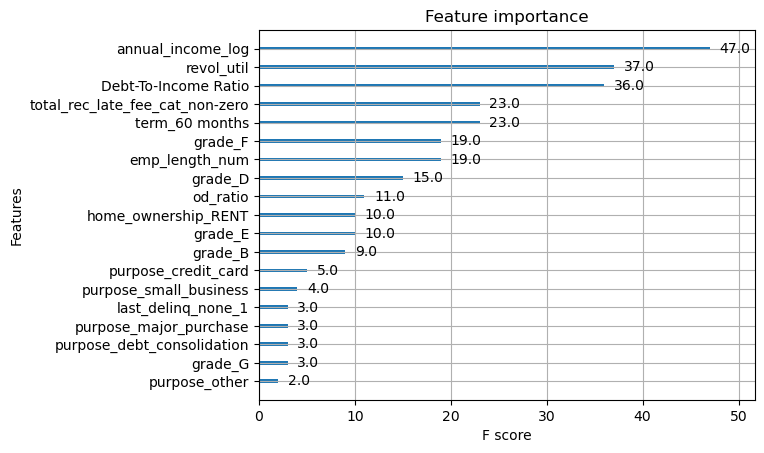

In [435]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [354]:
param_grid = [
    {'n_estimators': [440, 450, 460],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 5, 'n_estimators': 450}

In [355]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2888,49
Actual Positive,688,49


In [356]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.33. ROC AUC is 0.66, Accuracy is 0.80


In [357]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.18440730028470004),
 ('revol_util', 0.1710399181653364),
 ('annual_income_log', 0.16761629893687274),
 ('od_ratio', 0.16197703450194983),
 ('emp_length_num', 0.08646920887175863),
 ('term_60 months', 0.0250101497136873),
 ('last_delinq_none_1', 0.02492434790817975),
 ('home_ownership_RENT', 0.019995955091240837),
 ('grade_B', 0.01758318475985221),
 ('purpose_debt_consolidation', 0.016437226416608455),
 ('grade_D', 0.015254633176995042),
 ('total_rec_late_fee_cat_non-zero', 0.013369091733521831),
 ('purpose_credit_card', 0.013263378560304906),
 ('grade_C', 0.013237557484994045),
 ('grade_E', 0.01186520089408407),
 ('home_ownership_OWN', 0.01182384164794052),
 ('grade_F', 0.010400943619175915),
 ('purpose_home_improvement', 0.007904960897709224),
 ('purpose_other', 0.007628045543563687),
 ('purpose_major_purchase', 0.004765206955021151),
 ('purpose_small_business', 0.003918569454680535),
 ('grade_G', 0.0025363244131941186),
 ('purpose_medical', 0.0020203817490

### Gradient Descent Optimization

Stochastic Gradient Descent

In [360]:
param_grid = [
    {'max_iter': list(range(50, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_iter': 150}

In [361]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train, y_train)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1744,1193
Actual Positive,252,485


In [362]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.34. ROC AUC is 0.67, Accuracy is 0.61


Mini-batch Gradient Descent

In [364]:
from sklearn.base import clone

batch_size = 150
sample_size = len(X_train)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train, y_train))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train[list(train_ind)], y_train.iloc[train_ind], X_train[list(val_ind)], y_train.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,1744,1193
Actual Positive,252,485


In [365]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.34. ROC AUC is 0.67, Accuracy is 0.61


### Support Vector Machine

Linear SVM

In [368]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(10, 20, 2)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                        class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 10, 'max_iter': 4}

In [369]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1911,1026
Actual Positive,242,495


In [370]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.39. ROC AUC is 0.71, Accuracy is 0.65


Polynomial Kernel Support Vector Classifier

SVC's time complexity is $O(n^2 \times d)$ to $O(n^3 \times d)$. To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [373]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [374]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True,
                          class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 10, 'coef0': 2, 'degree': 1}

In [375]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test_2)
y_score = poly_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,7681,4069
Actual Positive,1027,1919


In [376]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.38. ROC AUC is 0.70, Accuracy is 0.65


Gaussian RBF Kernel Support Vector Classifier

In [378]:
param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True,
                         class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [379]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test_2)
y_score = rbf_kernel_svm_clf.predict_proba(X_test_2)[:, 1]

get_confusion_matrix(y_test_2, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,9365,2385
Actual Positive,1592,1354


In [380]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test_2, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.70, Accuracy is 0.73


### Stacking/Stacked Generalization

In [382]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1888,1049
Actual Positive,257,480


In [383]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.37. ROC AUC is 0.69, Accuracy is 0.64


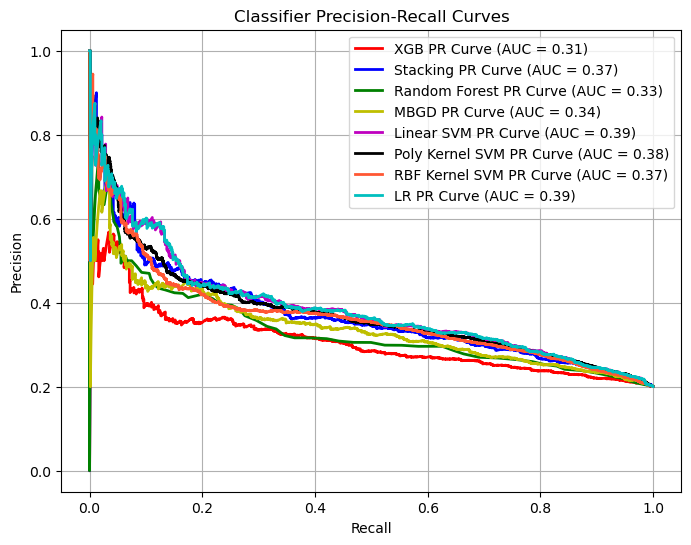

In [439]:
plt.figure(figsize=(8, 6))


plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

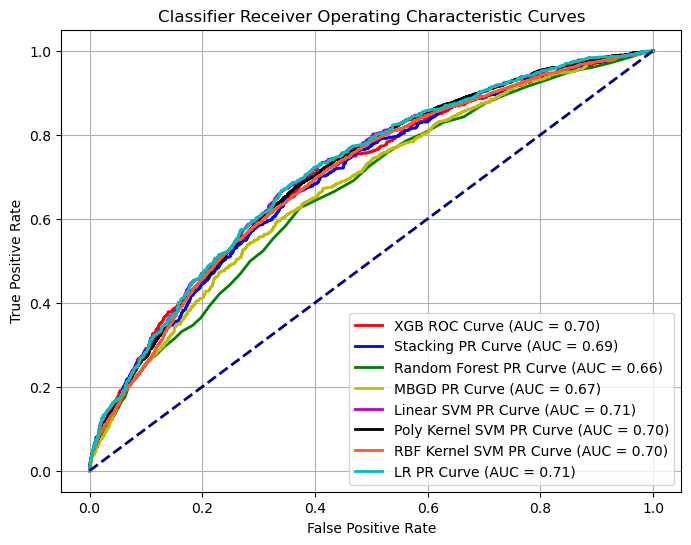

In [385]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

There seems to be an issue with the dataset as the PR AUCs are very low. Should I use SMOTE instead of the class_weight parameter to create a balanced training dataset? Or, should I relabel the target variable? The other Jupyter notebooks explore these two quesitons. In smote.ipynb, I will use SMOTE to create a balanced dataset for training and see if the classifers will perform better.